In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils import data
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [0]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.cuda.current_device(), torch.cuda.device_count()

(0, 1)

In [0]:
batch_size = 100

train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,), (0.5,))
                       ])),
        batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.5,), (0.5,))
                    ])),
    batch_size=batch_size, shuffle=True)

train_loader, test_loader

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!



/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


(<torch.utils.data.dataloader.DataLoader at 0x7f9cde006978>,
 <torch.utils.data.dataloader.DataLoader at 0x7f9c807e4dd8>)

In [0]:
??nn.ConvTranspose2d

In [0]:
class Generator(nn.Module):
  def __init__(self):
    '''
    Network is a map from one image to another image
    (Batch, 1, w, h) -> (Batch, 1, w, h)
    (Batch, 1, w, h) -> 2ConvDown -> Flatten -> FC -> Bottleneck -> FC -> Reshape -> 2ConvUp -> (Batch, 1, w, h)
    '''
    super(Generator, self).__init__()
    self.fc1 = nn.Linear(128, 256)
    self.fc2 = nn.Linear(256, 512)
    self.fc3 = nn.Linear(512, 1024)
    self.fc4 = nn.Linear(1024, 784)

  def forward(self, z):
    # Down
    z = self.fc1(z)
    z = nn.LeakyReLU(0.2)(z)
    z = self.fc2(z)
    z = nn.LeakyReLU(0.2)(z) 
    z = self.fc3(z)
    z = nn.LeakyReLU(0.2)(z)
    z = self.fc4(z)
    z = nn.Tanh()(z)
    z = z.view((-1, 1, 28, 28))
    return z 


class Discriminator(nn.Module):
  def __init__(self):
    '''
    Network is a map from an image to (0, 1)
    (Batch, 1, w, h) -> (Batch, )
    '''
    super(Discriminator, self).__init__()
    self.fc1 = nn.Linear(784, 1024)
    self.fc2 = nn.Linear(1024, 512)
    self.fc3 = nn.Linear(512, 256)
    self.fc4 = nn.Linear(256, 1)

  
  def forward(self, x):
    x = x.view((-1, 784))
    x = self.fc1(x)
    x = nn.LeakyReLU(0.2)(x)
    x = self.fc2(x)
    x = nn.LeakyReLU(0.2)(x)
    x = self.fc3(x)
    x = nn.LeakyReLU(0.2)(x)
    x = self.fc4(x)
    return (x)


generator = Generator()
discriminator = Discriminator()
generated = generator(torch.randn(10, 128))

predictions = discriminator(generated)
next(discriminator.parameters()).is_cuda

True

In [0]:
G = Generator()
D = Discriminator()

G_optimizer = optim.Adam(G.parameters(), lr = 1e-4)
D_optimizer = optim.Adam(D.parameters(), lr = 1e-4)


def train(G, D, G_optimizer, D_optimizer, train_loader, criterion):
  G_losses = []
  D_losses = []
  transform = transforms.Compose([
    transforms.Normalize(mean=[0.5,],
                         std=[0.5,])])
  D_grads = 0
  for i, (X, Y) in enumerate(train_loader):
    
    # train D
    Z = torch.randn((X.shape[0], 128))
    D.zero_grad()
    X = X.cuda()
    for p in D.parameters(): p.requires_grad = True
    D_loss = criterion(D(X), torch.ones((X.shape[0], 1))) + criterion(D(G(Z)), torch.zeros((X.shape[0], 1)))
    D_loss.backward(retain_graph=True)
    D_optimizer.step()

    # train G
    G.zero_grad()
    for p in D.parameters(): p.requires_grad = False
    
    G_loss = criterion(D(G(Z)), torch.ones((X.shape[0], 1)))

    G_loss.backward()
    G_optimizer.step()
    
    G_losses.append(G_loss.mean().item())
    D_losses.append(D_loss.mean().item())
    D_grads += sum([x.grad.sum() for x in D.parameters()])
  return D_grads.item()


def validate(G, D, test_loader):
  D_losses = []
  G_losses = []
  for i, (X, Y) in enumerate(test_loader):
    Z = torch.randn((X.shape[0], 128))
    X = X.cuda()
    D_loss = nn.BCEWithLogitsLoss()(D(X), torch.ones((X.shape[0], 1))) + nn.BCEWithLogitsLoss()(D(G(Z)), torch.zeros((X.shape[0], 1)))
    G_loss = nn.BCEWithLogitsLoss()(D(G(Z)), torch.ones((X.shape[0], 1)))
    D_losses.append(D_loss.item())
    G_losses.append(G_loss.item())
  return sum(D_losses) / len(D_losses), sum(G_losses) / len(G_losses)


vanilla_train_D_losses = []
vanilla_train_G_losses = []
vanilla_test_D_losses = []
vanilla_test_G_losses = []
vanilla_D_grads = []
for epoch in range(20):
  D_grads = train(G, D, G_optimizer, D_optimizer, train_loader, nn.BCEWithLogitsLoss())
  D_train_loss, G_train_loss = validate(G, D, train_loader)
  D_test_loss, G_test_loss = validate(G, D, test_loader)
  vanilla_train_D_losses.append(D_train_loss)
  vanilla_train_G_losses.append(G_train_loss)
  vanilla_test_D_losses.append(D_test_loss)
  vanilla_test_G_losses.append(G_test_loss)
  vanilla_D_grads.append(D_grads)
  print(epoch, D_train_loss, G_train_loss, D_test_loss, G_test_loss, D_grads)

0 0.007098380734678358 5.251410919825236 0.007186153386719525 5.239679307937622 -81867.28125
1 1.485745810866356 0.7718314775824546 1.458698320388794 0.773635219335556 -96763.328125
2 1.7557849717140197 0.6813558129469554 1.7210032153129577 0.6816789954900742 -21116.990234375
3 0.6933100758989652 1.5463926148414613 0.6703984469175339 1.5533172750473023 -16262.4462890625
4 0.28317722126841544 2.681951805750529 0.2724164763092995 2.677890591621399 -40927.64453125
5 0.39921839646995066 4.2797645584742225 0.3644161753356457 4.266320893764496 -2186.205078125
6 0.49294293959935503 3.6253692213694255 0.4566254475712776 3.5967805194854736 -20791.427734375
7 0.19307719574620327 4.0416479635238645 0.18084774792194366 4.041655700206757 -22693.697265625
8 0.2426580854008595 3.563074883619944 0.24222129844129087 3.5569009351730347 -16302.712890625
9 0.18499002527445554 3.2871685282389325 0.1807719711214304 3.276175181865692 -26073.287109375
10 0.3552126371363799 2.793499341805776 0.318126655369997 

In [0]:
G = Generator()
D = Discriminator()

G_optimizer = optim.Adam(G.parameters(), lr = 1e-4)
D_optimizer = optim.Adam(D.parameters(), lr = 1e-4)

def lsgan_train(G, D, G_optimizer, D_optimizer, train_loader):
  G_losses = []
  D_losses = []
  transform = transforms.Compose([
    transforms.Normalize(mean=[0.5,],
                         std=[0.5,])])
  D_grads = 0
  for i, (X, Y) in enumerate(train_loader):
    
    # train D
    Z = torch.randn((X.shape[0], 128))
    D.zero_grad()
    X = X.cuda()
    for p in D.parameters(): p.requires_grad = True
    D_loss = torch.mean((D(X) - 1) ** 2) + torch.mean(D(G(Z))** 2)
    D_loss.backward(retain_graph=True)
    D_optimizer.step()

    # train G
    G.zero_grad()
    for p in D.parameters(): p.requires_grad = False
    
    G_loss = torch.mean((D(G(Z)) - 1) ** 2)

    G_loss.backward()
    G_optimizer.step()
    
    G_losses.append(G_loss.mean().item())
    D_losses.append(D_loss.mean().item())
    D_grads += sum([x.grad.sum() for x in D.parameters()])
  return D_grads.item()


def lsgan_validate(G, D, test_loader):
  D_losses = []
  G_losses = []
  for i, (X, Y) in enumerate(test_loader):
    Z = torch.randn((X.shape[0], 128))
    X = X.cuda()
    D_loss = torch.mean((D(X) - 1) ** 2) + torch.mean(D(G(Z))** 2)
    G_loss = torch.mean((D(G(Z)) - 1) ** 2)
    D_losses.append(D_loss.item())
    G_losses.append(G_loss.item())
  return sum(D_losses) / len(D_losses), sum(G_losses) / len(G_losses)


lsgan_train_D_losses = []
lsgan_train_G_losses = []
lsgan_test_D_losses = []
lsgan_test_G_losses = []
lsgan_D_grads = []
for epoch in range(20):
  D_grads = lsgan_train(G, D, G_optimizer, D_optimizer, train_loader)
  D_train_loss, G_train_loss = lsgan_validate(G, D, train_loader)
  D_test_loss, G_test_loss = lsgan_validate(G, D, test_loader)
  lsgan_train_D_losses.append(D_train_loss)
  lsgan_train_G_losses.append(G_train_loss)
  lsgan_test_D_losses.append(D_test_loss)
  lsgan_test_G_losses.append(G_test_loss)
  lsgan_D_grads.append(D_grads)
  print(epoch, D_train_loss, G_train_loss, D_test_loss, G_test_loss, D_grads)




0 0.009389001687522977 1.0367376120885212 0.009046091199852526 1.0368039345741271 -656.7423095703125
1 0.026924112001433968 0.953295039832592 0.02619913412258029 0.9520184171199798 -4306.0380859375
2 0.030888673192821445 0.898793844183286 0.031226962730288507 0.8968929767608642 -9203.63671875
3 0.021156578003428878 0.9979965257644653 0.02065524226985872 0.9966447746753693 -1194.85107421875
4 0.012250107836443931 0.9433636684219042 0.012010319205000997 0.943834200501442 -573.3889770507812
5 0.0034615192837857954 0.9957740618785222 0.003528431076556444 0.9958921998739243 -349.7980041503906
6 0.0031146335027491053 0.9886494926611582 0.003056748628150672 0.9890676724910736 -1002.9805297851562
7 0.007860312590685984 0.9260141750176748 0.007696460923179984 0.9252230489253997 -596.7741088867188
8 0.0024960930631884063 0.9627696454524994 0.0022899902355857193 0.9621945041418075 -128.0499267578125
9 0.006368466278072447 0.9177174745996793 0.006591102653183043 0.917053673863411 -741.167175292968

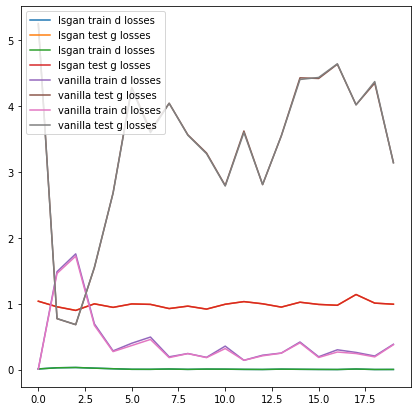

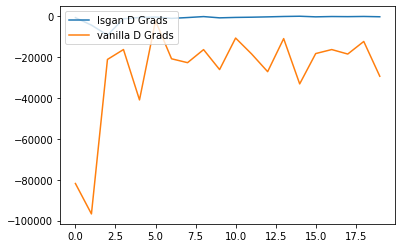

In [0]:
plt.figure(figsize=(7, 7))
plt.plot(range(0, 20), lsgan_train_D_losses, label = 'lsgan train d losses')
plt.plot(range(0, 20), lsgan_train_G_losses, label = 'lsgan test g losses')
plt.plot(range(0, 20), lsgan_test_D_losses, label = 'lsgan train d losses')
plt.plot(range(0, 20), lsgan_test_G_losses, label = 'lsgan test g losses')
plt.plot(range(0, 20), vanilla_train_D_losses, label = 'vanilla train d losses')
plt.plot(range(0, 20), vanilla_train_G_losses, label = 'vanilla test g losses')
plt.plot(range(0, 20), vanilla_test_D_losses, label = 'vanilla train d losses')
plt.plot(range(0, 20), vanilla_test_G_losses, label = 'vanilla test g losses')
plt.legend(loc='upper left')
plt.show()

plt.plot(range(0, 20), lsgan_D_grads, label = 'lsgan D Grads')
plt.plot(range(0, 20), vanilla_D_grads, label = 'vanilla D Grads')
plt.legend(loc='upper left')
plt.show()

torch.Size([10, 128])
tensor(-12.7953) -515.401


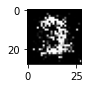

tensor(-0.0599) -452.0


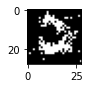

tensor(17.9077) -452.0


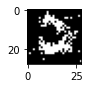

tensor(16.4850) -451.99927


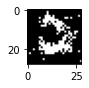

tensor(-15.2782) -467.47916


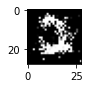

tensor(4.4406) -451.90955


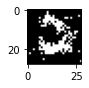

tensor(-13.6163) -461.65314


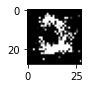

tensor(-3.1896) -449.41708


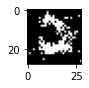

tensor(-11.4873) -452.00015


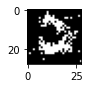

tensor(9.9147) -452.00037


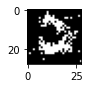

In [0]:
def tensor2image(x):
  return x.detach().numpy().transpose(0, 2, 3, 1)

def image2tensor(x):
  return torch.tensor(x.transpose(0, 3, 1, 2))

def display_image(image):
  plt.figure(figsize=(1,1))
  plt.imshow(image[:,:,0], cmap = 'gray')
  plt.show()


transform = transforms.Compose([
  transforms.Normalize(mean=[0.5,],
                        std=[0.5,])])
inputs = torch.randn((10, 128))
print(inputs.shape)
predictions = G(inputs).cpu()
predictions_numpy = tensor2image(predictions.cpu())
for j, (inpt, prediction) in enumerate(zip(inputs, predictions_numpy)):
  print(inpt.sum(), prediction.sum())
  display_image(prediction)
  if j > 30:
    break